# HW3: The Centralized Curator Model

### Bhaven Patel
### 4/2/2019

I worked with Anthony Rentsch and Lipika Ramaswamy on this homework.

My code can be found on my [Github](https://github.com/bhavenp/cs208/blob/master/homework/HW3/HW3_Bhaven_Patel.ipynb).

## Problem 1: Tails, Trimming, and Winsorization


**(a)**<br>

$$
M(x)=\dfrac{1}{0.9n}\left(\sum_{P_0.05 \leq x_i \leq P_0.95} x_i\right) + Lap\left( \dfrac{D}{0.9n\epsilon} \right)
$$

This implementation of the Trimmed mean is $\epsilon$-DP if the trimming transformation $T$ on $x$ ($x$ is trimmed from its 5th to its 95th percentile) is c-Lipschitz and the mechanism $M$ is $\epsilon$-DP.

First, we can show that the trimming transformation $T$ on $x$ is c-Lipschitz:<br>
Begin with $x$ and $x'$, which hold $n$=20 values each in the range [0,...,D]
$$
x = [x_1, ..., x_{20}]\\
x' = [x_2, ..., x_{21}]\\
$$

The trimming transformation $T$ applied to $x$ and $x'$ would result in
$$
T(x) = [x_2, ..., x_{19}]\\
T(x') = [x_3, ..., x_{20}]\\
$$

$T(x)$ is $c$-Lipschitz if $\forall x,x' \;\; d(T(x), T(x')) \leq c\cdot d(x, x')$, where $d(x, x')$ denotes the distance between datasets $x$ and $x'$. In this case, $d(x, x') = 1$ and $d(T(x), T(x')) = 1$, so $c=1$. Thus, $T(x)$ is $c$-Lipschitz.

A mechanism $M$ is $\epsilon$-DP when adding Laplace noise sampled from $Lap\left(\dfrac{GS}{\epsilon}\right)$, where $GS$ is the global sensitivity. In our case, the $GS = \dfrac{D}{0.9n}$ and we are adding $Lap\left(\dfrac{D}{0.9n\epsilon}\right)$ noise, so our mechanism is $\epsilon$-DP. From the lemma in class, since $M$ is $\epsilon$-DP and $T$ is $c$-Lipschitz, then $M\circ T$ is $c\epsilon$-DP. Thus, this Trimmed mean algorithm is $\epsilon$-DP.


The code for the implementation is below

In [1]:
rm(list=ls())		# Remove any objects in memory

#### Parameters ####

# Random draw from Laplace distribution
#
# mu numeric, center of the distribution
# b numeric, spread
# size integer, number of draws
# 
# return Random draws from Laplace distribution
# example:
# 
# rlap(size=1000)

rlap = function(mu=0, b=1, size=1) {
    p <- runif(size) - 0.5
    draws <- mu - b * sgn(p) * log(1 - 2 * abs(p))
    return(draws)
}

# Sign function
# 
# Function to determine what the sign of the passed values should be.
#
# x numeric, value or vector or values
# return The sign of passed values
# example:
#
# sgn(rnorm(10))


sgn <- function(x) {
    return(ifelse(x < 0, -1, 1))
}

In [2]:
# Generate a dataset of size
#
# max_value- maximum value any element in the dataset should take on
# size- number of elements to include in dataset
# 
# returns a differentially private mean release from the trimmed data

create_dataset = function(max_value, size){
    return(sample(0:max_value, size = size, replace = TRUE));
}

In [4]:
# Trimmed mean function for releasing a DP mean from data trimmed to its 5% to 95% intervals
#
# x- numeric vector of values
# max_value- maximum value any element in 'x' may take
# epsilon- privacy loss parameter
# 
# returns a differentially private mean release from the trimmed data

trimmed_mean = function(x, max_value, epsilon){
    n <- length(x); #get number of elements in x
    #get 5% and 95% cutoff values
    cutoffs <- quantile(x, probs = c(0.05, 0.95) )
    lower = cutoffs[1];
    upper = cutoffs[2];
    x.trimmed <- x[x > lower & x< upper]; #trim x
    
    sensitivity <- max_value/ (0.9*n);
    scale <- sensitivity / epsilon; #scale for Laplace noise

    sensitiveValue <- mean(x.trimmed)
    DPrelease <- sensitiveValue + rlap(mu=0, b=scale, size=1)

    return(list(release=DPrelease, true=sensitiveValue));
}

In [43]:
max_value = 10;
size = 20;

test <- create_dataset(max_value, size);
print(test)

trimmed_mean(test, max_value = max_value, epsilon = 0.4)

 [1] 9 9 1 5 9 2 5 5 1 9 9 5 2 8 5 2 5 1 2 1


$release
[1] 4.496269

$true
[1] 4.181818

<hr>

**(a)**<br>
Create a data generating function that samples from the Poisson distribution.

In [2]:
# Random draws from Poisson distribution
#
# mean- numeric, mean of the distribution
# size integer, number of draws
# 
# return Random draws from Laplace distribution
# example:
# 
# sample_poisson(num_draws=1000)

sample_poisson <- function(mean=10, num_draws=1){
	data = rpois(n = num_draws, lambda = mean);
    return(data);
}

**(b)**<br>
I picked the first mechanism from Problem 1: $M(x) = [\bar{x} + Z]_0^1$, $Z \sim Lap \left(\dfrac{GS}{\epsilon} \right)$

In [3]:
# Sign function
# 
# Function to determine what the sign of the passed values should be.
#
# x numeric, value or vector or values
# return The sign of passed values
# example:
#
# sgn(rnorm(10))
# Taken from James Honaker's histogramRelease.r
sgn <- function(x) {
    return(ifelse(x < 0, -1, 1))
}

# Random draw from Laplace distribution
#
# mu numeric, center of the distribution
# b numeric, spread
# size integer, number of draws
# 
# return Random draws from Laplace distribution
# example:
# 
# rlap(size=1000)
# Taken from James Honaker's histogramRelease.r
rlap = function(mu=0, b=1, size=1) {
    p <- runif(size) - 0.5
    draws <- mu - b * sgn(p) * log(1 - 2 * abs(p))
    return(draws)
}

## Clip a variable to a range. Taken from James Honaker's histogramRelease.r
clip <- function(x, lower, upper){
	x.clipped <- x
	x.clipped[x.clipped<lower] <- lower
	x.clipped[x.clipped>upper] <- upper
	return(x.clipped)
}

## Differentially private mean release. Taken from James Honaker's laplaceMeanReleaseFull.r
meanRelease <- function(x, lower=0, upper, epsilon){
    n <- length(x); #get number of data points/observations
    
    sensitivity <- (upper - lower)/n; #calculate GS
    scale <- sensitivity / epsilon; #calculate scale for laplace noise

    x.clipped <- clip(x, lower, upper);
    sensitiveValue <- mean(x.clipped);
    DPrelease <- sensitiveValue + rlap(mu=0, b=scale, size=1);
    DPrelease <- clip(DPrelease, lower, upper); #clip the DP-mean if it lower/greater than the desired bounds
    
    return(list(release=DPrelease, true_clipped=sensitiveValue ));
}

**(c)**<br>
For n=200 and $\epsilon$=0.5, plot the root mean squared error as a function of the upper bound b

In [4]:
#set parameters
n = 200;
epsilon = 0.5;
num_sims = 10; #number of simulations to run for each upper bound

In [5]:
#set the seed
set.seed(24);

b_vals = seq(from = 1, to=100); #create sequence of upper bounds

datasets <- matrix(NA, nrow=n, ncol=num_sims);
#generate 'num_sims' different datasets from Poisson distribution
for(i in 1:num_sims){
    datasets[,i] = sample_poisson(num_draws = n); #put i-th dataset in column i
}
dataset_means = colMeans(datasets); #calculate mean for each dataset

#create matrix to hold upper bound and rmse for mean DP-releases, average mean
rmse_vals = matrix(NA, nrow=length(b_vals), ncol=3); 
for(b in b_vals){
    dp_means = c(); #vector to hold DP-released means for each simulation
    for(i in 1:num_sims){
        results = meanRelease(datasets[,i], lower = 0, upper = b, epsilon = epsilon); #get mean release
        dp_means <- c(dp_means, results$release);
    }
    
    #calculate RMSE
    rmse = ( sum( (dp_means - dataset_means)**2 ) / length(dp_means)) ** 0.5; 
    rmse_vals[b,] <- c(b, rmse, mean(dp_means));
}


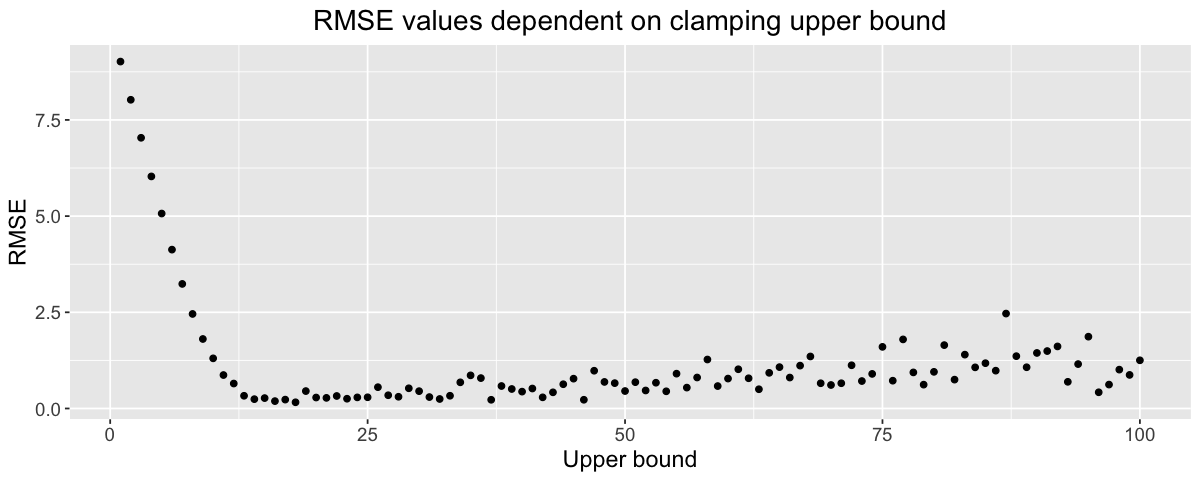

In [6]:
library(ggplot2); #import library for plotting
library(grid);

#### Plot results ####
final_results <- as.data.frame(rmse_vals);
colnames(final_results) <- c("Upper_bound", "RMSE", "Average true mean");
f_size = 16;
fifty = 0.5;
# Plot average RMSE of reconstruction against noise input
p_rmse <- ggplot(data = final_results, aes(x=final_results$Upper_bound, y=final_results$RMSE)) + geom_point();
p_rmse <- p_rmse + labs(title="RMSE values dependent on clamping upper bound", x="Upper bound", y = "RMSE") + theme(plot.title = element_text(hjust=0.5), text = element_text(size=f_size-2));
options(repr.plot.width=10, repr.plot.height=4); #set plot dimensions
p_rmse #show plot

In [7]:
print(final_results[final_results$RMSE == min(final_results$RMSE), ]);

   Upper_bound     RMSE Average true mean
18          18 0.161492          9.954823


The optimal value $b^{*}$ is 18. From the graph, it looks like values from 16 to 18 all have comparable RMSE values and could be used as good upper bounds.

**(d)**<br>
If we generate an optimal value $b^*$ based on bootstrapped samples from our dataset $x$, then we may leak information about outliers in the our dataset. This would occur because some of the bootstraps will contain the outliers, and their RMSE's will be minimized when the upper bound for clipping is near or greater than the value of the outlier. Thus by looking at the graph of average RMSE versus upper bound for the bootstrapped samples, it is possible to infer what the values of the outliers could be. This would not be differentially private because outliers in the dataset could be identified. Additionally by choosing the $b^*$ based on the dataset, we would most likely overfit to the dataset.

**(e)**<br>
If we have some idea of what the data universe looks like (we have some prior), we could generate many alternative/synthetic datasets and calculate the best upper bound based on those synthetic datasets. This would prevent us from leaking any private information from our own dataset. If we don't have this prior, we could build a DP histogram and build multiple synthetic datasets from this DP histogram; these synthetic datasets would then be used to calculate the best upper bound.

## Problem 3: Regression

**(a)**<br>

To produce a differentially-private release of $\hat\alpha$, I will create differentially private releases of the covariance of $x$ and $y$ ($S_{xy}$), the variance of $x$ ($S_{xx}$), the mean of $y$ ($\bar{y}$), and the mean of $x$ ($\bar{x}$). If our privacy budget is $\epsilon$, each of these releases will take a fraction of the privacy budget equal to $\dfrac{\epsilon}{4}$, and due to the composition rule, the total privacy loss will be at most $\epsilon$.<br>
$\hat\beta$ and $\hat\alpha$ can be calculated from the differentially private releases of $S_{xy}$, $S_{xx}$, $\bar{y}$, and $\bar{x}$ as follows:
$$
\hat\beta = \dfrac{S_{xy}}{S_{xx}}\\
\hat\alpha = \bar{y} - \hat\beta \bar{x}\\
$$
<br><br>
Below is my augmentation to the regression release code so that I also give a differentially private release of $\hat\alpha$.

In [5]:
## Differentially private regression slope release. Modified from laplaceRegressionRelease.r by James Honaker.
regressionRelease <- function(y, x, ylower, yupper, xlower, xupper, epsilon_parts){
	x.clipped <- clip(x, xlower, xupper)
	y.clipped <- clip(y, ylower, yupper)

	n <- length(x)
	sens.Sxy <- ((xupper-xlower)*(yupper-ylower))  
	sens.Sxx  <- ((xupper-xlower)^2)  

	scale.Sxy <- sens.Sxy / (epsilon_parts$Sxy);
	scale.Sxx <- sens.Sxx / (epsilon_parts$Sxx);

	sensitiveValue <- sum((x.clipped - mean(x.clipped))*(y.clipped - mean(y.clipped))) / sum((x.clipped -
                                                                                              mean(x.clipped))^2); 

    #get DP-releases of Sxy and Sxx to calculate beta-hat
    release.Sxy <- sum((x.clipped - mean(x.clipped))*(y.clipped - mean(y.clipped)))  + rlap(mu=0, b=scale.Sxy, size=1); 
	release.Sxx <- sum((x.clipped - mean(x.clipped))^2)              + rlap(mu=0, b=scale.Sxx, size=1);
    #get DP-releases of x-bar and y-bar to calculate alpha-hat
    release.xbar <- meanRelease(x, lower = xlower, upper = xupper, epsilon = epsilon_parts$xbar)$release;
    release.ybar <- meanRelease(y, lower = ylower, upper = yupper, epsilon = epsilon_parts$ybar)$release;
    
    #calculate beta-hat and alpha-hat
	postprocess.beta <- release.Sxy/release.Sxx;
    postprocess.alpha <- release.ybar - postprocess.beta * release.xbar;
    
    true.alpha = mean(y.clipped) - sensitiveValue * mean(x.clipped); #calculate the true alpha of the clipped values
	return(list(dp_beta=postprocess.beta, true_beta=sensitiveValue, dp_alpha=postprocess.alpha,
                true_alpha=true.alpha))
}

First, I want to find a good upper bound for clamping the y's.

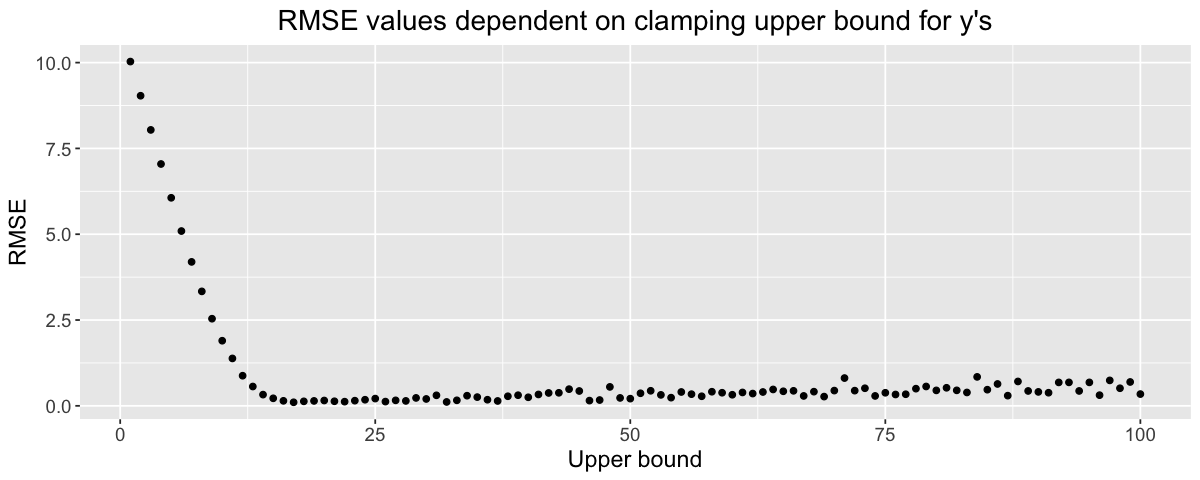

In [9]:
#set the seed
set.seed(24);

n = 200;
num_sims = 10; #number of simulations to run for each upper bound
alpha = beta = sigma = epsilon = 1;

b_vals = seq(from = 1, to=100); #create sequence of upper bounds

datasets <- matrix(NA, nrow=n, ncol=num_sims);
#generate 'num_sims' different datasets from Poisson distribution
for(i in 1:num_sims){
    x_data = sample_poisson(num_draws = n); 
    datasets[,i] = alpha*x_data + beta + rnorm(n=n, mean=0, sd=sigma); #put i-th dataset in column i
}
dataset_means = colMeans(datasets); #calculate mean for each dataset

#create matrix to hold upper bound and rmse for mean DP-releases, average mean
rmse_vals = matrix(NA, nrow=length(b_vals), ncol=3); 
for(b in b_vals){
    dp_means = c(); #vector to hold DP-released means for each simulation
    for(i in 1:num_sims){
        results = meanRelease(datasets[,i], lower = 0, upper = b, epsilon = epsilon); #get mean release
        dp_means <- c(dp_means, results$release);
    }
    
    #calculate RMSE
    rmse = ( sum( (dp_means - dataset_means)**2 ) / length(dp_means)) ** 0.5; 
    rmse_vals[b,] <- c(b, rmse, mean(dp_means));
}

#### Plot results ####
library(ggplot2)
final_results <- as.data.frame(rmse_vals);
colnames(final_results) <- c("Upper_bound", "RMSE", "Average true mean");
f_size = 16;
fifty = 0.5;
# Plot average RMSE of reconstruction against noise input
p_rmse <- ggplot(data = final_results, aes(x=final_results$Upper_bound, y=final_results$RMSE)) + geom_point();
p_rmse <- p_rmse + labs(title="RMSE values dependent on clamping upper bound for y's", x="Upper bound", y = "RMSE") + theme(plot.title = element_text(hjust=0.5), text = element_text(size=f_size-2));
options(repr.plot.width=10, repr.plot.height=4); #set plot dimensions
p_rmse #show plot

In [10]:
print(final_results[final_results$RMSE == min(final_results$RMSE), ]);

   Upper_bound      RMSE Average true mean
17          17 0.1037066          10.96932


I will use an upper bound of 18 for $x$ and an upper bound of 17 for $y$.

**(b)**<br>

In [8]:
#set the seed
set.seed(24);

#set parameters
y_lower = 0;
y_upper = 17;
x_lower = 0;
x_upper = 18;


n = 1000; #size of the dataset
num_sims = 1000; #number of Monte Carlo simulations to run
alpha = beta = sigma = epsilon = 1;

#define partitions for epsilon, which should all be epsilon/4
epsilon_parts = list(Sxy=epsilon/4, Sxx=epsilon/4, xbar=epsilon/4, ybar=epsilon/4);

#create matrix to hold upper bound and rmse for mean DP-releases, average mean
rmse_vals = matrix(NA, nrow=num_sims, ncol=3); 
for(i in 1:num_sims){
    #generate x-data and y-data
    x_data = sample_poisson(num_draws = n); 
    y_data = beta*x_data + alpha + rnorm(n=n, mean=0, sd=sigma);
    #get regression release beta and alpha
    reg_release <- regressionRelease(y_data, x_data, ylower=y_lower, yupper=y_upper, 
                                     xlower=x_lower, xupper=x_upper, epsilon_parts=epsilon_parts);

    #calculate y for each x point in dataset using regression release statistics
    y_dp <- reg_release$dp_beta * x_data + reg_release$dp_alpha;
    y_nondp <- reg_release$true_beta * x_data + reg_release$true_alpha; #calc y using non-dp stats
    #calculate RMSE for the DP release stats
    rmse_dp = sum( (y_dp - y_data)**2 ) / length(y_data);
    #calculate RMSE for the non-DP release stats
    rmse_nondp = sum( (y_nondp - y_data)**2 ) / length(y_data); 

    rmse_vals[i,] <- c(i, rmse_dp, rmse_nondp); #put RMSE values into matrix
}

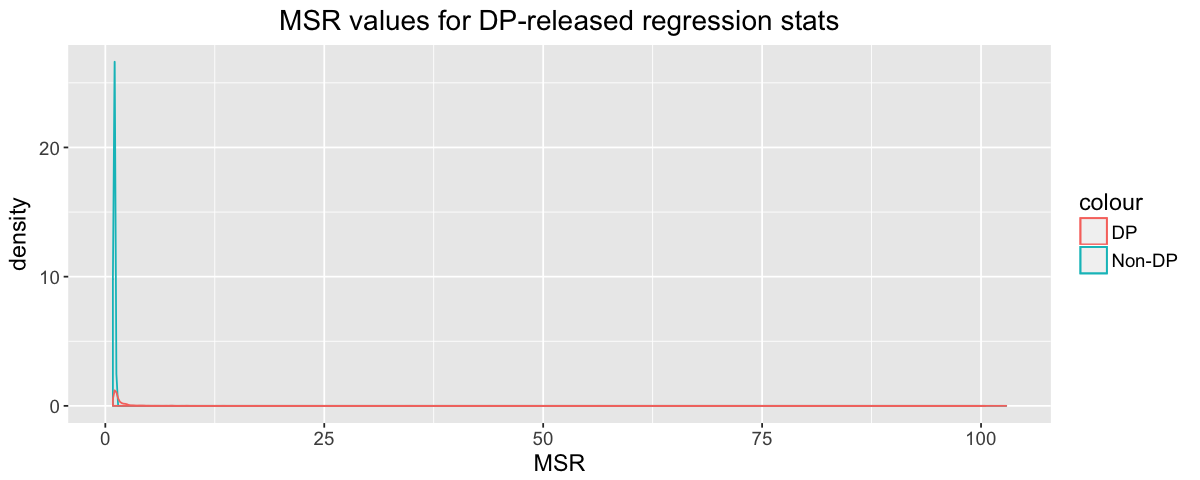

In [10]:
#### Plot results ####
library(ggplot2)
final_results <- as.data.frame(rmse_vals);
colnames(final_results) <- c("Simulation", "MSE_DP", "MSE_nonDP");
f_size = 16;

# Plot average RMSE of reconstruction against noise input #
#geom_density
p_rmse <- ggplot(data = final_results) + geom_density(aes(x=final_results$MSE_nonDP, color='Non-DP')) + geom_density(aes(x=final_results$MSE_DP, color='DP' ));
p_rmse <- p_rmse + labs(title="MSR values for DP-released regression stats", x="MSR", y="density") + theme(plot.title = element_text(hjust=0.5), text = element_text(size=f_size-2));
options(repr.plot.width=10, repr.plot.height=4); #set plot dimensions

p_rmse #show plot

The distribution of mean-squared residuals for the differentially private released regression stats is right-skewed because some of the stats must receive a large amount of noise from the Laplace distribution resulting in very high residuals for some DP-releases.

**(c)**<br>

In [23]:
#create a vector with values from 0.1 to 0.9
eps_to_test <- seq(0.1,0.9,0.1);

#create data frame of all combination of values from vectors
eps_combos_to_test <- as.data.frame(expand.grid(list(a=eps_to_test, b=eps_to_test, c=eps_to_test, d=eps_to_test) ));

In [37]:
#normalize values in each row so they add up to 1
eps_combos_to_test_norm = eps_combos_to_test / rowSums(eps_combos_to_test)
# eps_combos_to_test_norm

#remove the duplicates
dups = which(duplicated(eps_combos_to_test_norm));
eps_combos_to_test_norm = eps_combos_to_test_norm[-dups, ];
print(paste("I need to test", nrow(eps_combos_to_test_norm), "combinations") ); 

[1] "I need to test 6223 combinations"


In [92]:
set.seed(24); #set the seed for reproducible results

#get a single dataset to test on
x_data = sample_poisson(num_draws = n);
y_data = alpha*x_data + beta + rnorm(n=n, mean=0, sd=sigma);

num_sim = 10;

#create matrix to hold epsilon partitions and MSR for DP-releases
partition_res = matrix(NA, nrow=nrow(eps_combos_to_test_norm), ncol=5); 

#go through each epsilon partition I calculated
for(i in 1:nrow(eps_combos_to_test_norm)){
    epsilon_parts = list(Sxy=eps_combos_to_test_norm[i,1], Sxx=eps_combos_to_test_norm[i,2],
                         xbar=eps_combos_to_test_norm[i,3], ybar=eps_combos_to_test_norm[i,4]);
    msr_vec = c();
    for(j in 1:num_sim){
        #get regression release beta and alpha
        reg_release <- regressionRelease(y_data, x_data, ylower=y_lower, yupper=y_upper, 
                                     xlower=x_lower, xupper=x_upper, epsilon_parts=epsilon_parts);

        #calculate y for each x point in dataset using regression release statistics
        y_dp <- reg_release$dp_beta * x_data + reg_release$dp_alpha;

        #calculate RMSE for the DP release stats
        msr_dp = sum( (y_dp - y_data)**2 ) / length(y_data);
        msr_vec = c(msr_vec, msr_dp);
    }
    
    partition_res[i,] <- c( as.numeric(eps_combos_to_test_norm[i, ]), mean(msr_dp) ); #put partition values and mean of MSR values with these partition values into the matrix
}

#convert the results to a data frame
partition_res_df = as.data.frame(partition_res);

In [93]:
#give columns names
colnames(partition_res_df) <- c("Sxy_eps", "Sxx_eps", "xbar_eps", "ybar_eps", "MSR");
#sort based on MSR
partition_res_df <- partition_res_df[order(partition_res_df$MSR), ];
partition_res_df[1:5, ]

,Sxy_eps,Sxx_eps,xbar_eps,ybar_eps,MSR
2692,0.1666667,0.11111111,0.5000000,0.22222222,0.9843554
3318,0.3103448,0.27586207,0.2413793,0.17241379,0.9844241
5853,0.3333333,0.08333333,0.2083333,0.37500000,0.9844889
637,0.2916667,0.33333333,0.3333333,0.04166667,0.9845111
6217,0.2571429,0.22857143,0.2571429,0.25714286,0.9845811


In [94]:
median_msr <- median(final_results$MSE_DP);
print(paste("Median MSR for DP release with equal epsilion partitions from (b):", median_msr) );
print("Mean MSR for DP release with for best parition:");
partition_res_df[1,]


[1] "Median MSR for DP release with equal epsilion partitions from (b): 1.24757505362371"
[1] "Mean MSR for DP release with for best parition:"


,Sxy_eps,Sxx_eps,xbar_eps,ybar_eps,MSR
2692,0.1666667,0.1111111,0.5,0.2222222,0.9843554


To determine the best partition of $\epsilon$ for the four regression stats releases $S_{xy}$, $S_{xx}$, $\bar{x}$, and $\bar{y}$, I calculated DP-releases for a single dataset 10 times for each partition of $\epsilon$. I decided to to do a DP-release on the same dataset 10 times so that the only noise in the results was derived from the Laplace noise added to the regression stats each time they were calculated. I tested 6223 different partitions of $\epsilon$ for the four regression stats and found that the above partition gave the best mean-squared residual on the single dataset. The mean-squared residual for my best partition gave better utility than the equal partition that I tested in part (b). Several other partitions of $\epsilon$ gave almost identical results to my best partition, suggesting there may be several good choices. From the top five scoring partitions, it does not seem like giving a higher or lower partition to any of the DP-released stats is better; the values for all them seem to jump around quite a bit.
<br>
Another strategy for choosing the best partition would be to create 10 different datasets, calculate the mean-squared error for a given $\epsilon$ partition for each dataset, and compare the averages of the mean-squared error of all the different partitions.

<hr>

## Problem 4: DP vs. Reconstruction Attacks

$$
E[\# \{i\in[n]: A(M(X))_i = X_i\} /n]
$$
represents the expected fraction of bits the attacker can reconstruct. This can be written as

$$\begin{align}
&=\dfrac{1}{n} E[\# \{i\in[n]: A(M(X))_i = X_i\}] \\
&= \dfrac{1}{n} \sum_{i=1}^n P[ A(M(X_i, X_{-i})) = X_i] \\
\end{align}$$
where $X_i$ is the row the attacker is trying to reconstruct and $X_{-i}$ is all elements in the dataset except $X_i$. Using the definition of $(\epsilon,\delta)$-DP and the rule of post-processing, we can write

$$
\leq \dfrac{1}{n} e^{\epsilon} \sum_{i=1}^n P[ A(M(0, X_{-i})) = X_i] + \delta
$$

We change $X_i \rightarrow 0$ because the attacker should not be able to learn anything about one individual from a differentially private release. Anything the attacker learns couuld have been learned by the attacker even without the query.
<br>
Now, the best strategy for the attacker to employ is to assume that everyone in the dataset has a sensitive bit equal to the bit with the highest probability. We have a binary case where $X_i\in\{0,1\}$, and the probabilities of each case can be written as $P[ A(M(0, X_{-i})) = 0]=(1-p)$ and $P[ A(M(0, X_{-i})) = 1]=(p$ respectively. If we take the max of the two probabilities, our expression can be written as
$$\begin{align}
&\leq \dfrac{1}{n} e^{\epsilon} \sum_{i=1}^n max\left(P[ A(M(0, X_{-i})) = 0], P[ A(M(0, X_{-i})) = 1] \right)+ \delta\\
&\leq \dfrac{1}{n} e^{\epsilon} \sum_{i=1}^n max\left(1-p, p\right)+ \delta \\
&\leq \dfrac{1}{n} e^{\epsilon} (n) max\left(1-p, p\right)+ \delta \\
&\leq e^{\epsilon} max\left(1-p, p\right)+ \delta \\
\end{align}$$

Since $e^{\epsilon} \geq 1$, the adversary can reconstruct a fraction of bits slightly larger than just predicting the $max\left(1-p, p\right)$.

## Problem 5: Final Project Next Step

This will be submitted separately on Gradescope.